### Naive Bayes Probability Estimates Are Inaccurate

The Naive Bayes model is an example of a *probabilistic graphical model*. In particular, it is the simplest example of a *Bayesian Network*.

**(Run this cell to define useful Latex macros)**
\\[
\newcommand{\card}[1]{\left\lvert#1\right\rvert}
\newcommand{\condbar}[0]{\,\big|\,}
\newcommand{\eprob}[1]{\widehat{\text{Pr}}\left[#1\right]}
\newcommand{\norm}[1]{\left\lvert\left\lvert#1\right\rvert\right\rvert}
\newcommand{\prob}[1]{\text{Pr}\left[#1\right]}
\newcommand{\set}[1]{\left\{#1\right\}}
\\]

In [1]:
import lib.dataset
from lib.naive_bayes_evaluator import NaiveBayesEvaluator
from lib.naive_bayes_model import NaiveBayesModel

RAW_DATASET = lib.dataset.RawDataset.get()
(training_set, test_set) = RAW_DATASET.split(ratio = 0.80)

print(f"total_number of emails: {len(RAW_DATASET.ham_emails) + len(RAW_DATASET.spam_emails)}")
print(f"number of training emails: {len(training_set.ham_emails) + len(training_set.spam_emails)}")
print(f"number of test emails: {len(test_set.ham_emails) + len(test_set.spam_emails)}")

model = NaiveBayesModel(
    training_set.feature_probabilities().filter(reach_limit = 100),
    use_negative_features = False
)

print(NaiveBayesEvaluator.spam_probability_at_different_scores(
    model,
    test_set
))

ModuleNotFoundError: No module named 'lib'

### Naive Bayes Can Answer Any Query

Let's recall the assumption that underlies our Naive Bayes model:

\\[
\begin{align}
\prob{W_1 = w_1, \ldots, W_k = w_k \condbar \text{SPAM} = 1}
&=
\prob{W_1 = w_1 \condbar \text{SPAM} = 1}
\cdots
\prob{W_k = w_k \condbar \text{SPAM} = 1}
\\
\prob{W_1 = w_1, \ldots, W_k = w_k \condbar \text{SPAM} = 0}
&=
\prob{W_1 = w_1 \condbar \text{SPAM} = 0}
\cdots
\prob{W_k = w_k \condbar \text{SPAM} = 0}
\end{align}
\\]

This is our conditional independence assumption. In fact, let's take it further:

\\[
\begin{align}
&\prob{W_1 = w_1, \ldots, W_k = w_k, \text{SPAM} = 1}\\
&=
\prob{\text{SPAM} = 1}
\prob{W_1 = w_1, \ldots, W_k = w_k \condbar \text{SPAM} = 1}
\\
&=
\prob{\text{SPAM} = 1}
\prob{W_1 = w_1 \condbar \text{SPAM} = 1}
\cdots
\prob{W_k = w_k \condbar \text{SPAM} = 1}
\end{align}
\\]

Now, our Naive Bayes is responsible for finding all those terms: the basic spam/ham probabilities, as well as the conditional (single) feature probabilities. Therefore our Naive Bayes can be used to calculate this probability.

Notice that *every* variable is specified in this equation. This is very significant. This let's us use our Naive Bayes model to answer *any* statistical *query*.

Let me give you an example. Consider if I want to calculate $\prob{\text{BALDNESS} = 1 \condbar \text{INVESTMENT} = 1}$. We know that this is not just $\prob{\text{BALDNESS} = 1}$ because "baldness" is *not* unconditionally on "investment", because investment indicates a spam email, and a spam email likely has baldness.

So to calculate this, consider all the settings of $\set{\text{SPAM}, W_1, \ldots, W_k}$. There are $2^{k + 1}$ of these, because they are all binary variables. Throw away all settings where the $w_i$ corresponding to "investment" is zero. Since I gave you the formula for calculating a probability if all variables are specified, go ahead and do that. Sum these probabilities up. You now have $\prob{\text{INVESTMENT} = 1}$.

Next, take that set and ignore those settings where $w_j$ for "baldness" is zero. Again, calculate the probabilities of each individual setting. Sum up. You now have $\prob{\text{BALDNESS} = 1 \wedge \text{INVESTMENT} = 1}$.

Last, calculate the ratio:

\\[
\frac{
    \prob{\text{BALDNESS} = 1 \wedge \text{INVESTMENT} = 1}
}{
    \prob{\text{INVESTMENT} = 1}
}
\\]

This is the definition of $\prob{\text{BALDNESS} = 1 \condbar \text{INVESTMENT} = 1}$!

From this point of view, the ability to answer the query $\prob{\text{SPAM} = 1 \condbar W_1 = w_1, \ldots, W_k = w_k}$ is just a special case of the Naive Bayes model's ability to answer *any* kind of query.

### Naive Bayes Is A Generative Model

We've seen that Naive Bayes assigns a probability to every setting of the variables $\set{SPAM, W_1, \ldots W_k}$.

What I want to do is *generate* new emails. And I want the probability that I generate a particular email E with some specific $w_1, \ldots w_k$ values be exactly the probability that Naive Bayes would say that email would have under the equation:

\\[
\begin{align}
&\prob{W_1 = w_1, \ldots, W_k = w_k}
\\
&=\prob{\text{SPAM} = 0}
\prob{W_1 = w_1, \ldots, W_k = w_k \condbar \text{SPAM} = 0}\\
&\quad+
\prob{\text{SPAM} = 1}
\prob{W_1 = w_1, \ldots, W_k = w_k \condbar \text{SPAM} = 1}
\\
&=
\prob{\text{SPAM} = 0}
\prob{W_1 = w_1 \condbar \text{SPAM} = 0}\cdots\prob{W_k = w_k \condbar \text{SPAM} = 0}
\\
&\quad+
\prob{\text{SPAM} = 1}
\prob{W_1 = w_1 \condbar \text{SPAM} = 1}\cdots\prob{W_k = w_k \condbar \text{SPAM} = 1}
\end{align}
\\]

There's an easy way to do this. First let's sample a random number between zero and one. Call this $x$. If $x < \prob{\text{SPAM} = 1}$, then let's pretend that this generated email is spam. Otherwise let's pretend it's ham. Note that if we do this, our probability of generating a spam email is exactly $\prob{\text{SPAM} = 1}$. Let $s = 1$ if the email is spam, and $s = 0$ otherwise.

Now let's generate the words. We can actually do this in any order we want, because they are all conditionally independent. Let's be reasonable and start with $W_1$. Again, sample an $x$ from zero to one. Put the word $W_1$ in the email if $x < \prob{W_1 = 1 \condbar \text{SPAM} = s}$.

Repeat this for all the words. At the end you will end up with a bag of words, which is your email. The probability of this particular bag of words is exactly like we said, because each word was generated independently, so the probability of generating the bag (given $s$) was indeed:

\\[
\prob{W_1 = w_1 \condbar \text{SPAM} = s}\cdots\prob{W_k = w_k \condbar \text{SPAM} = s}
\\]

### Generative Versus Discriminative

Let me give a better example for contrast. Consider a system that is trained to detect whether an image is of a cat or a dog. This system may know how to *detect* a cat or a dog, but it might now know how to *draw* a cat or a dog. A system that can only detect is called a *discriminative model*.

More generally, any system that can only answer one kind of query (or a limited set of queries) is called discriminative. For the cat detection problem, we want to know $\prob{\text{CAT} = 1 \condbar \text{the values of every pixel}}$.

A *generative* model can be used to generate images. For instance, it could be used to select values for all the pixels based on the probability distribution $\prob{\text{the values of every pixel} \condbar \text{CAT} = 1}$. In this case, it would draw a cat.

Generative models are typically more powerful because they let us answer more kinds of queries. Discriminative models are one-trick ponies.

On the other hand, discriminative models have a much easier job to do. Recognizing cats (I can tell you) is much harder than drawing them. You often need much more data to train a generative model well.

In particular, our Naive Bayes model will generate stupid bags of words that would never appear in an email. That's because it doesn't know what words go together. Basically: the Naive Bayes model doesn't know how to write English.

To teach a more powerful model how to write English, we would need way more text than is in the Enron dataset.

Therefore, if you have a particular task in mind, a discriminative model can often do a better job with less data.


### Naive Bayes Is A Graphical Model

Naive Bayes can be naturally thought of as a *probabilistic graphical model*. Models like this are also called PGMs.

What is a PGM? I think an image will show better than I can say:

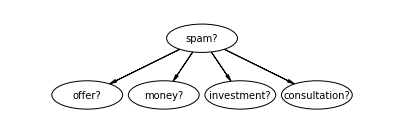

In [8]:
%matplotlib inline
import daft

ASPECT = 2.5

def run():
    pgm = daft.PGM([7, 2])

    class_node = pgm.add_node(daft.Node(
        "spam?",
        "spam?",
        y = 1.5, x = (ASPECT / 2 + 0.1) * 2.5, aspect = ASPECT
    ))

    words = [
        "offer?",
        "money?",
        "investment?",
        "consultation?"
    ]

    for idx, word in enumerate(words):
        node = daft.Node(
            word, word, y = 0.5, x = (ASPECT / 2 + 0.1) * (idx + 1), aspect = ASPECT
        )
        pgm.add_node(node)
        pgm.add_edge("spam?", word, directed = True)

    pgm.render()
run()

The idea is this. Every vertex contains a variable. There is an edge from "spam?" to "offer?" because whether the word "offer" appears depends on whether the email is spam.

At each vertex, there is a table that maps every setting of the *parent* variables to a proability distribution. For instance, if the email is spam, we use one $\prob{\text{OFFER?} = 1\condbar \text{SPAM?} = 1}$, while if the email is ham we use a different $\prob{\text{OFFER?} = 1\condbar \text{SPAM?} = 0}$.

For the spam vertex, which has no parents, there's just one unconditional probability: $\prob{\text{SPAM?} = 1}$.

We can generate samples from the distribution by generating parent values before child values. In this case, we decide whether an email is spam, and then use that to generate the individual words.

It turns out we can come up with a *different* graph for the Naive Bayes model.

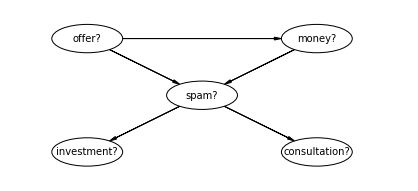

In [9]:
%matplotlib inline

import daft

ASPECT = 2.5

def run():
    pgm = daft.PGM([7, 3])

    offer_node = pgm.add_node(daft.Node(
        'offer?',
        'offer?',
        y = 2.5,
        x = (ASPECT / 2 + 0.1) * 1,
        aspect = ASPECT,
    ))
    money_node = pgm.add_node(daft.Node(
        'money?',
        'money?',
        y = 2.5,
        x = (ASPECT / 2 + 0.1) * 4,
        aspect = ASPECT,
    ))
    pgm.add_edge('offer?', 'money?')

    spam_node = pgm.add_node(daft.Node(
        'spam?',
        'spam?',
        y = 1.5,
        x = (ASPECT / 2 + 0.1) * 2.5,
        aspect = ASPECT
    ))
    pgm.add_edge('offer?', 'spam?', directed = True)
    pgm.add_edge('money?', 'spam?', directed = True)

    words = [
        ('investment?', 1),
        ('consultation?', 4),
    ]

    for word, position in words:
        node = daft.Node(
            word,
            word,
            y = 0.5,
            x = (ASPECT / 2 + 0.1) * position,
            aspect = ASPECT
        )
        pgm.add_node(node)
        pgm.add_edge('spam?', word, directed = True)

    pgm.render()
run()

This graph structure doesn't correspond to the Naive Bayes model structure. This model says:

1. First decide whether an email contains the word "offer."
2. Next, decide whether the email contains the word "money."
    * This choice will "depend" on offer, because, in reality, "offer" depends on whether an email is spam.
    * And "money" depends on whether an email is spam.
    * So we cannot decide whether an email contains "money" independently.
    * Ultimately this is because $\prob{\text{M} = 1 \condbar \text{O} = 0} \ne \prob{\text{M} = 1 \condbar \text{O} = 1}$.
3. Next, decide whether the email is spam.
    * This depends on both offer and money.
    * If neither is selected, then the email is less likely to be spam.
    * If both are selected, then the email is more likely to be spam.
    * If one is selected but not the other, the effect is intermediate.
    * In every case, the probability of whether an email is spam depends.
4. At this point, generate the rest of the words independently.

This graph structure is clearly silly. First, it doesn't map onto our intuition of how an email is generated. Also, it has created a dependent of "money?" on "offer?", even though this dependence could be eliminated if "spam?" were a parent of both.

This structure *hides* the conditional independence.

Anyway, it turns out that any model can always be cast as *some* probabilistical graphical model. In particular, consider:

\\[
\prob{X_1 = x_1, X_2 = x_2, \ldots, X_k = x_k}
=
\prob{X_1 = x_1}
\prob{X_2 = x_2 \condbar X_1 = x_1}
\prob{X_3 = x_3 \condbar X_1 = x_1, X_2 = x_2}
\cdots
\prob{X_k = x_k \condbar X_1 = x_1, \ldots X_{k - 1} = x_{k - 1}}
\\]

This is *always* true, by Bayes Rule. Let's see the graph!

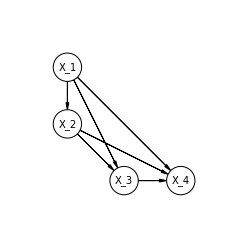

In [11]:
%matplotlib inline

import daft

def run():
    pgm = daft.PGM([4, 4])

    nodes = [
        (1, 3, 1),
        (2, 2, 1),
        (3, 1, 2),
        (4, 1, 3),
    ]

    for node in nodes:
        (num, y, x) = node
        pgm.add_node(daft.Node(
            f"X_{num}",
            f"X_{num}",
            x = x,
            y = y,
        ))
        for prev_num in range(1, num):
            pgm.add_edge(
                f"X_{prev_num}",
                f"X_{num}",
                directed = True,
            )

    pgm.render()
run()

This model has no interesting structure. Thus it is more natural to think of a Naive Bayes model as a PGM than it is to think just any old probability distribution, where there are no assumptions of independences.

Directed models like these are called *Bayes Networks* or just *Bayes Nets*. There is a related kind of model called a *Markov Network* or *Markov Random Field* that maybe we will talk about some day. A Markov Network uses *undirected* edges, but what these undirected edges mean will remain a mystery for now!